<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

[Home- go back to hadardestani.com](http://hadiardestani.com/)
# Credit Card Fraud Detection Practice

As a Data and Risk Analyst who works in Payment industry, I am facing the challenge of fraudulent transactions detection on daily basis in my workplace. There is not a day that I am not required to determine whether a suspicious transaction is Fraudulent or is legit. The line between a legit and fraudulent transactions is becoming closer and closer everyday as the fraudster are becoming more and more expert subject matter. It is obvious that they are always ahead us.  

Thinking about how an organization that processes large quantities of transactions per day (such as my company) is able to filter and detect those fraudulent transactions, made me dig dipper into the subject and try to understand the system. 

From the moment that a transaction is submitted for processing to the moment that it gets approved, a series of checks and balances takes place. There are many filters that a transactions information passes through, one of them is the fraud detection algorithm. This algorithm can be set prior to approval (real time fraud detection) or post approval (Post transactions analysis phase). The whole system is very complicated and sophisticated, and I am just trying to simplify so I can get to my focused point which is a Fraud Detection Machin Learning Algorithm. 

Below I am going to use a (probably the only one) publicly available credit card transactions dataset in order to build and examine a Fraud Detection model using python. I am doing this mostly for my own curiosity sack, and of course the fun of the challenge. 

# The Data set
The data set is available in Kaggle for free <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">see it here</a>. I am going just to copy and paste the dataset description from Kaggle: 
"The datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependent cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

In [1]:
#Importing the necessary Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")



In [6]:
#lets frist import the data and examine it.
df = pd.read_csv('creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [7]:
df.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.537294e-16  7.959909e-16  5.367590e-16  4.458112e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   1.453003e-15  1.699104e-15 -3.660161e-16 -1.206049e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

In [8]:
# to check if there are Null Values!
df.isnull().sum().max()

0

In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [10]:
#How many legit transcations 
df['Class'].value_counts()[0]

284315

In [11]:
#and how many Fraud transcations
df['Class'].value_counts()[1]

492

In [17]:
#Thier Percentage of the whole Data
print(round(df['Class'].value_counts()[0]/len(df) * 100,2),'% legit transcations')
print(round(df['Class'].value_counts()[1]/len(df) * 100,2),'% Frauded transcations')

99.83 % legit transcations
0.17 % Frauded transcations


In [18]:
# I like to use interactive visualization specially plotly  when the data set is not that big.# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [19]:
import plotly.express as px
fig = px.histogram(df, x="Class", color="Class")
fig.show()

**This just shows that the data is heavily imbalanced, which will cause trouble for our model later. what does that mean? well in short, this will cause Overfitting since most of the transactions are legit then our model will assume in most cases that a transaction is legit. To address that we need to sub sample our data by a 50/50 ratio of legit and fraud truncations. This will help our model better capture patterns of fraud vs legit transactions.**

** Additionally, it can be seen that almost all the columns are scaled except amount and time. We will need to scale those as well.

In [20]:
#First tgings first
fraud = df[df['Class']==1]
legit = df[df['Class']==0]
outlinears = len(fraud)/(len(legit)+len(fraud))
print('Outlinears: '+ str(outlinears))
print('# of fraud transcations = ' + str(len(fraud)))
print('# of legit transcations = ' + str(len(legit)))

Outlinears: 0.001727485630620034
# of fraud transcations = 492
# of legit transcations = 284315


In [21]:
# lets first go for scaling amount and time column.
from sklearn.preprocessing import StandardScaler, RobustScaler

#I am choosing to go with RobustScaler because it is less sensitive to outliers

std_scaler = StandardScaler()
rob_scaler = RobustScaler()


df['fixed_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['fixed_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


scaled_amount = df['fixed_amount']
scaled_time = df['fixed_time']

df.drop(['fixed_amount', 'fixed_time'], axis=1, inplace=True)
df.insert(0, 'fixed_amount', scaled_amount)
df.insert(1, 'fixed_time', scaled_time)

# Amount and Time are Scaled!

df.head()

fixed_amount  fixed_time        V1        V2        V3        V4        V5  \
0      1.783274   -0.994983 -1.359807 -0.072781  2.536347  1.378155 -0.338321   
1     -0.269825   -0.994983  1.191857  0.266151  0.166480  0.448154  0.060018   
2      4.983721   -0.994972 -1.358354 -1.340163  1.773209  0.379780 -0.503198   
3      1.418291   -0.994972 -0.966272 -0.185226  1.792993 -0.863291 -0.010309   
4      0.670579   -0.994960 -1.158233  0.877737  1.548718  0.403034 -0.407193   

         V6        V7        V8  ...       V20       V21       V22       V23  \
0  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838 -0.110474   
1 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672  0.101288   
2  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679  0.909412   
3  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274 -0.190321   
4  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Class  
0  0.066928  0.128539 -0.189115  0.133558 -0.021053      0  
1 -0.339846  0.167170  0.125895 -0.008983  0.014724      0  
2 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752      0  
3 -1.175575  0.647376 -0.221929  0.062723  0.061458      0  
4  0.141267 -0.206010  0.502292  0.219422  0.215153      0  

[5 rows x 31 columns]

**Now let's do the random sampling of the data and the shuffling the data. Since we have 492 fraud transactions then we will randomly pick 492 of the legit transactions in order to create an equally distributed dataset.**

In [22]:
df = df.sample(frac=1)

frauded = df.loc[df['Class'] == 1]
legited = df.loc[df['Class'] == 0][:492]

equally_distributed_df = pd.concat([frauded, legited])

# Shuffle dataframe rows
thenew_dataset = equally_distributed_df.sample(frac=1, random_state=42)

thenew_dataset.head()

fixed_amount  fixed_time         V1         V2         V3        V4  \
57643       4.024314   -0.431149  -1.801574  -0.510404   1.738068  1.704095   
120837      1.088521   -0.102374  -5.140723   3.568751  -5.896245  4.164720   
137597      1.372039   -0.028818   1.313726  -1.168423  -0.099724 -1.461302   
81186       0.330329   -0.303927  -4.384221   3.264665  -3.077158  3.403594   
15781       1.089779   -0.675208 -25.266355  14.323254 -26.823673  6.349248   

               V5        V6         V7         V8  ...       V20       V21  \
57643    0.172069  0.320769   1.213702   0.342505  ...  0.528991  0.162373   
120837  -4.091193 -1.989960  -5.472436   2.422821  ...  0.318995  1.131130   
137597  -1.126195 -0.696335  -0.508839  -0.219071  ... -0.085117 -0.468437   
81186   -1.938075 -1.221081  -3.310317  -1.111975  ... -0.141533  2.076383   
15781  -18.664251 -4.647403 -17.971212  16.633103  ...  1.658289  1.780701   

             V22       V23       V24       V25       V26       V27       V28  \
57643  -0.405597  0.744826  0.096116  0.090258 -0.314405 -0.076374  0.122440   
120837  0.118022 -0.332704  0.139941  0.324758 -0.180769  0.177810  0.661555   
137597 -1.287024  0.060182 -0.052531  0.219926 -0.537523 -0.013343  0.024838   
81186  -0.990303 -0.330358  0.158378  0.006351 -0.493860 -1.537652 -0.994022   
15781  -1.861318 -1.188167  0.156667  1.768192 -0.219916  1.411855  0.414656   

        Class  
57643       0  
120837      1  
137597      0  
81186       1  
15781       1  

[5 rows x 31 columns]

In [23]:
#Now let's check our our new datfarme
print('calss distribution:')
print(thenew_dataset['Class'].value_counts()/len(thenew_dataset))
fig = px.histogram(thenew_dataset, x="Class", color="Class")
fig.show()

calss distribution:
1    0.5
0    0.5
Name: Class, dtype: float64


**Majority of people they head to modeling the algorithm from here. However, I like to go with what is the best practice meaning digging the data a bit more. Performing a bit more in depth visualization will help understand the features and how they weigh in on our target (fraud transactions). So I start by performing some standard basic visualization such as correlations and box blot and so on**

In [15]:
# For this part I will be using seaborn library for the sack of using a different visualization tool.

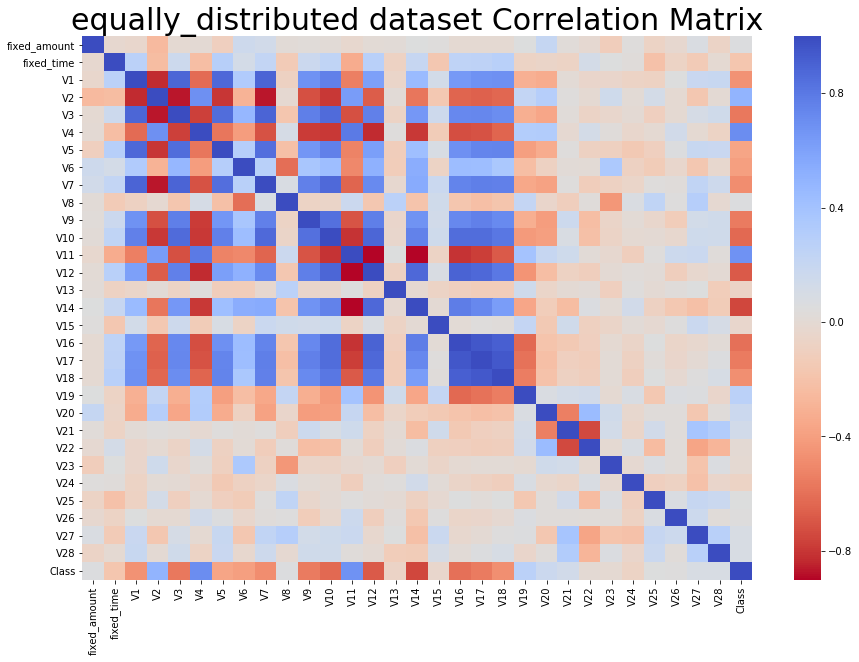

In [16]:
f, ax = plt.subplots(1,1,figsize=(15,10))
sub_sample_corr = thenew_dataset.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20})
ax.set_title('equally_distributed dataset Correlation Matrix', fontsize=30)
plt.show()

**Here is what I am seeing: V17, V14, V12 and V10 are standing out as they don't have a strong correlation with regards to frauded transactions and V2, V4, V11, and V19 are strongly correlated.**

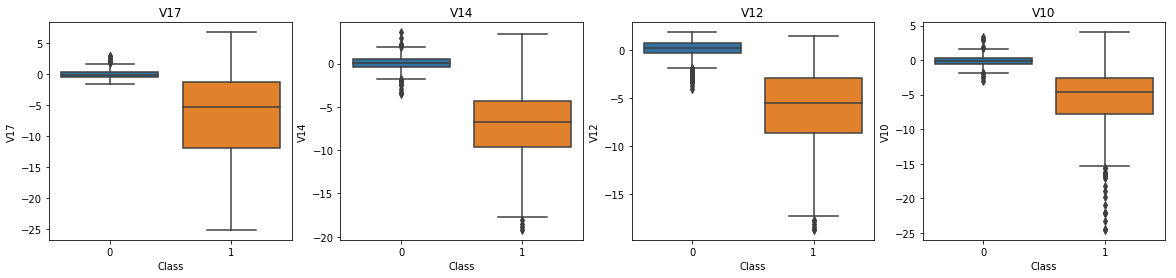

In [17]:
# let's dig into them dipper 
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# weak Correlations menas lower the value is the more likely it will be a fraud transaction
sns.boxplot(x="Class", y="V17", data=thenew_dataset, ax=axes[0])
axes[0].set_title('V17')

sns.boxplot(x="Class", y="V14", data=thenew_dataset, ax=axes[1])
axes[1].set_title('V14')


sns.boxplot(x="Class", y="V12", data=thenew_dataset, ax=axes[2])
axes[2].set_title('V12')


sns.boxplot(x="Class", y="V10", data=thenew_dataset, ax=axes[3])
axes[3].set_title('V10')

plt.show()

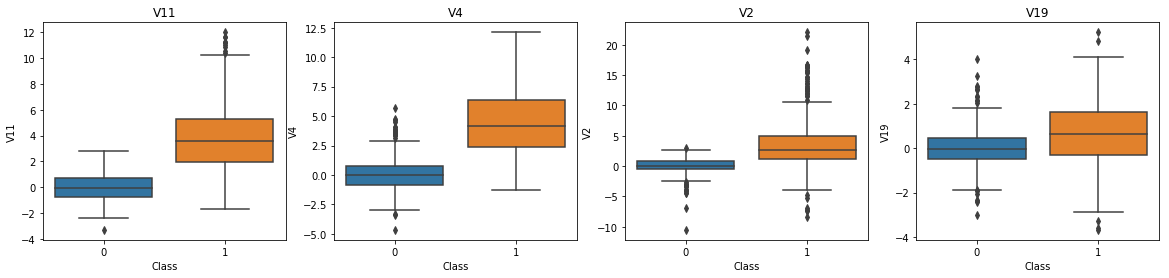

In [18]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Strong correlations means higher the feature the probability increases that it will be a fraud transaction
sns.boxplot(x="Class", y="V11", data=thenew_dataset, ax=axes[0])
axes[0].set_title('V11')

sns.boxplot(x="Class", y="V4", data=thenew_dataset, ax=axes[1])
axes[1].set_title('V4')


sns.boxplot(x="Class", y="V2", data=thenew_dataset, ax=axes[2])
axes[2].set_title('V2')


sns.boxplot(x="Class", y="V19", data=thenew_dataset, ax=axes[3])
axes[3].set_title('V19')

plt.show()

**As it can be seen there are a few outliers in V14, V12 and V10 which will impact accuracy of our model because these features have a strong correlation with our target feature. So, to improve the accuracy of our model it is best practice to remove these outliers from these features.**

In [19]:
# V14 Removing Outliers
fraudedv14 = thenew_dataset['V14'].loc[thenew_dataset['Class'] == 1].values
q25, q75 = np.percentile(fraudedv14, 25), np.percentile(fraudedv14, 75)
iqr_v14 = q75 - q25
cutoff_17 = iqr_v14 * 1.5
v14_lower, v14_upper = q25 - cutoff_17, q75 + cutoff_17
outliers = [x for x in fraudedv14 if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
thenew_dataset = thenew_dataset.drop(thenew_dataset[(thenew_dataset['V14'] > v14_upper) | (thenew_dataset['V14'] < v14_lower)].index)



Feature V14 Outliers for Fraud Cases: 4


In [20]:
# Reapeat the same for V12 

fraudedV12 = thenew_dataset['V12'].loc[thenew_dataset['Class'] == 1].values
q25, q75 = np.percentile(fraudedV12, 25), np.percentile(fraudedV12, 75)
iqr_V12 = q75 - q25
cutoff_17 = iqr_V12 * 1.5
V12_lower, V12_upper = q25 - cutoff_17, q75 + cutoff_17
outliers = [x for x in fraudedV12 if x < V12_lower or x > V12_upper]
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
thenew_dataset = thenew_dataset.drop(thenew_dataset[(thenew_dataset['V12'] > V12_upper) | (thenew_dataset['V12'] < V12_lower)].index)


Feature V12 Outliers for Fraud Cases: 4


In [21]:
# Reapeat the same for V10 
fraudedV10 = thenew_dataset['V10'].loc[thenew_dataset['Class'] == 1].values
q25, q75 = np.percentile(fraudedV10, 25), np.percentile(fraudedV10, 75)
iqr_V10 = q75 - q25
cutoff_17 = iqr_V10 * 1.5
V10_lower, V10_upper = q25 - cutoff_17, q75 + cutoff_17
outliers = [x for x in fraudedV10 if x < V10_lower or x > V10_upper]
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
thenew_dataset = thenew_dataset.drop(thenew_dataset[(thenew_dataset['V10'] > V10_upper) | (thenew_dataset['V10'] < V10_lower)].index)


Feature V10 Outliers for Fraud Cases: 27


**ok now we can procced with modeling our algorithm. I am going to start with comparison of 5 different classifiers and will look at their performance, accuracy and learning curve. This helps us understand which one is better to be picked and employed later.**
I have to mention that I spent a great deal of time researching and figuring out how to make the plots. This was fun and helped me learn a lot by doing so. I also was inspired by the work of Janio Martinez a Kaggle master. He has done a beautiful job working on this project in his kernel.

In [22]:
#Let's start bydefining my X (is all features ecxept our target) and Y (is our target)
X = thenew_dataset.drop(['Class'], axis=1)
y = thenew_dataset['Class']
# Then split the data into the train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [79]:
# Let's implement simple classifiers
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import collections

classifiers = {
    "Naive Bayes": GaussianNB(),
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}

# Model Evaluation
We perform model evaluation in order to answer questions such as how is out model performing? is it doing a good job? 
Is introducing more data into out train sets will improve put model performance? How about if I introduce more features into my model? 
There are many different metrics that are used to evaluate models. I will be evaluating our models using a few of the most common metrics such as Confusion Metrix, Accuracy Ratio, Precision, Recall. These metrices are used for classification models. Other types of models have their own metrices such as Mean squared error for Regression models and so on.

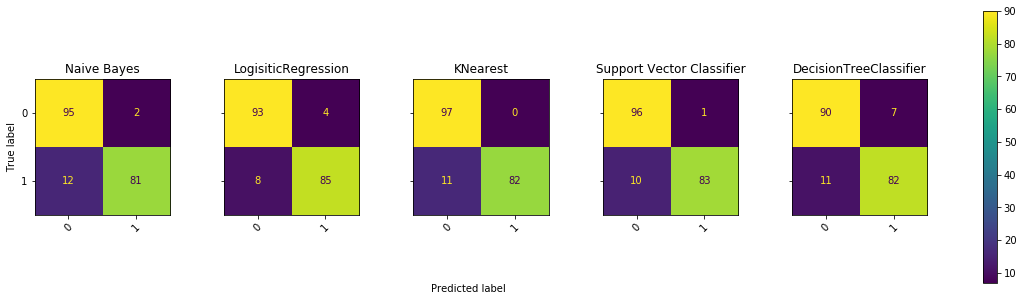

In [78]:
#of course there are many ways and toold to plot confusion matrix. I am going to show 2 of them that I know. #ConfusionMatrixDisplay is the easist of. 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=thenew_dataset['Class'])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


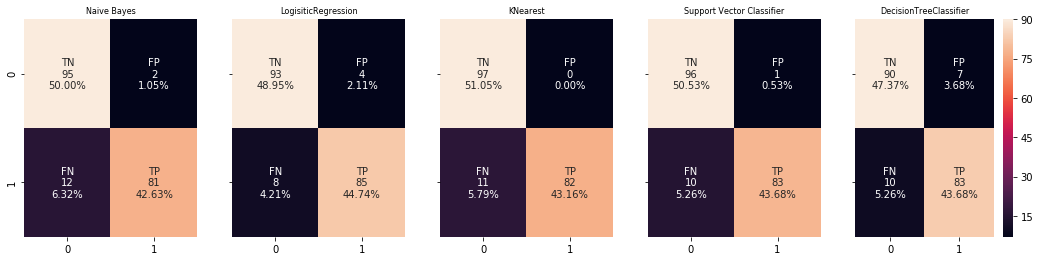

In [85]:
# We also can plot confusion matrix using seaborn and matplotlib

#from sklearn.metrics import confusion_matrix
#cf_matrix = dict.fromkeys(classifiers.keys())
#for key, classifier in classifiers.items(): 
    #y_pred = classifier.fit(X_train, y_train.ravel()).predict(X_test)
    #cf_matrix[key]=confusion_matrix(y_test, y_pred)

#Adding lables to them
fig, axn = plt.subplots(1,5, sharex=True, sharey=True,figsize=(18,4))
for i, ax in enumerate(axn.flat):
    k = list(cf_matrix)[i]
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix[k].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix[k].flatten()/np.sum(cf_matrix[k])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix[k], ax=ax,cbar=i==4,annot=labels, fmt='')
    ax.set_title(k,fontsize=8)
    
#TN= True Negatives: The number of correctly classified as legit transcation.
#FP= False Positives: The number of wrongly classified as Fraud transcation.
#FN= False Negatives: The number of wrongly classified as legit transcation.
#TP= True Positives: The number of correctly classified as Fraud transcation.




**Accuracy is defined as the percentage of correct predictions for the test data. It can be calculated easily by dividing the number of correct predictions by the number of total predictions.**

In [87]:
#Now, Let's check the accuracy ratio of our models
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

GaussianNB Has a training score of 92.0 % accuracy score
LogisticRegression Has a training score of 93.0 % accuracy score
KNeighborsClassifier Has a training score of 94.0 % accuracy score
SVC Has a training score of 93.0 % accuracy score
DecisionTreeClassifier Has a training score of 90.0 % accuracy score


**It is been proven that k-Nearest Neighbors does a better job for binary classification, which is the special case of distinguishing between exactly two classes (here we have legit vs fraud transcations). You can think of binary classification as trying to answer a yes/no question (is the transcation legit(no) or fraud(yes).Looking at the confusion matrixs and accuracy score, I am able to say that k-Nearest Neighbors is a better model in this case study. So I am going to fucus on k-Nearest Neighbors for thr rest.**

# Evaluating the Model

**Quote from Scikit Learn: "The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important."**

In [158]:
classifier_final = KNeighborsClassifier()
classifier_final.fit(X_train, y_train)
y_pred = classifier_final.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        97
           1       1.00      0.88      0.94        93

    accuracy                           0.94       190
   macro avg       0.95      0.94      0.94       190
weighted avg       0.95      0.94      0.94       190



In [159]:
print("Test set score: {:.2f}".format(classifier_final.score(X_test, y_test)))

Test set score: 0.94


**Quote from Scikit Learn:Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).
A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.**

In [160]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.94


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.94')

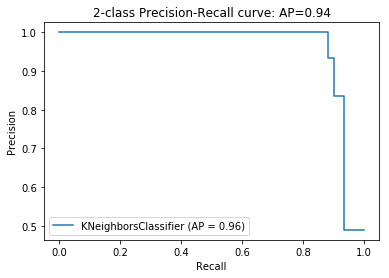

In [161]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(classifier_final, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

**The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).**

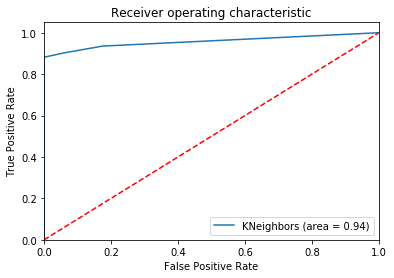

In [163]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier_final.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier_final.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNeighbors (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Validation curves
Quote from Scikit Learn: Every estimator has its advantages and drawbacks. Its generalization error can be decomposed in terms of bias, variance and noise. The bias of an estimator is its average error for different training sets. The variance of an estimator indicates how sensitive it is to varying training sets. Noise is a property of the data.Bias and variance are inherent properties of estimators and we usually have to select learning algorithms and hyperparameters so that both bias and variance are as low as possible. Another way to reduce the variance of a model is to use more training data. However, you should only collect more training data if the true function is too complex to be approximated by an estimator with a lower variance.

# learning curve
**In short, we use Learning curves as a diagnostic tool during training to show whether if our model has a problem with learning or not. Has a problem means if our model is underfit or overfit. The shape of the curve will define if the model is fit, underfit, or overfit. From the below plot, it appears that our KNeighbors model it is good enough fit. It is not ideal, but it is not bad either.

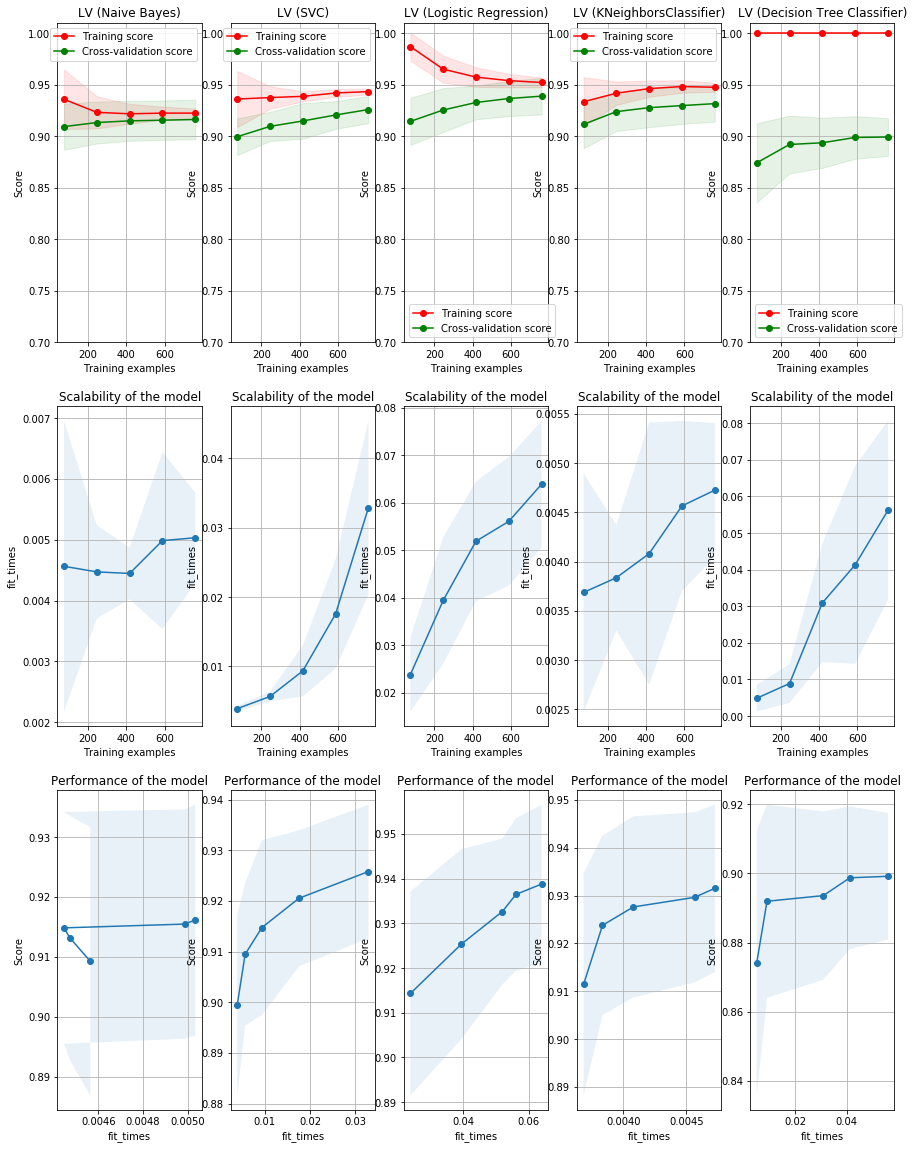

In [164]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

### below is the result of hours of search and finally going through the scikit-learn documention. 
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 5, figsize=(15, 20))

X = thenew_dataset.drop(['Class'], axis=1)
y = thenew_dataset['Class']

title = "LV (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "LV (SVC)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "LV (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "LV (KNeighborsClassifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 3], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "LV (Decision Tree Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 4], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)


plt.show()


With that I am going to assume that my model is working perfectly and deploy it. Of course it is not that simple and this wes all just an example and test for me to practice what I leanred and learn more trhough this practice. Some the sources that I used during working on this project are below:

1- Introduction to Machine Learning with Python by Andreas C. Müller and Sarah Guido
2- How to use Learning Curves to Diagnose Machine Learning Model Performance by Jason Brownlee
3- Credit Fraud || Dealing with Imbalanced Datasets by Janio Martinez
4- Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron

Cheers.